In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler
from utils.test_handler import ACDC2017TestHandler
from plotting.learning_curves import loss_plot

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
CYCLE_OFFSET = 100000

In [22]:
exper_base = ExperimentHandler.load_experiment("/home/jorg/repository/dcnn_acdc/logs/20180308_12_04_41_dcnnv1_150000E_lr2e02")
exper_hdl_base = ExperimentHandler(exper_base, use_logfile=False)
exper_hdl_base.set_root_dir(ROOT_DIR)

Load from /home/jorg/repository/dcnn_acdc/logs/20180308_12_04_41_dcnnv1_150000E_lr2e02/stats/exper_stats.dll


In [9]:
# Mixed model 1 (0.5)
exper_mc_mix = ExperimentHandler.load_experiment("/home/jorg/repository/dcnn_acdc/logs/20180312_07_51_21_dcnn_mcv1_150000E_lr2e02")
exper_hdl_mc_mix = ExperimentHandler(exper_mc_mix, use_logfile=False)
exper_hdl_mc_mix.set_root_dir(ROOT_DIR)

Load from /home/jorg/repository/dcnn_acdc/logs/20180312_07_51_21_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll


In [8]:
# Mixed model 2 (0.2)
exper_mc_mix2 = ExperimentHandler.load_experiment("/home/jorg/repository/dcnn_acdc/logs/20180313_08_23_55_dcnn_mcv1_150000E_lr2e02")
exper_hdl_mc_mix2 = ExperimentHandler(exper_mc_mix2, use_logfile=False)
exper_hdl_mc_mix2.set_root_dir(ROOT_DIR)


Load from /home/jorg/repository/dcnn_acdc/logs/20180313_08_23_55_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll


In [4]:
exper_mc = ExperimentHandler.load_experiment("/home/jorg/repository/dcnn_acdc/logs/20180308_12_05_35_dcnn_mcv1_150000E_lr2e02")
exper_hdl_mc = ExperimentHandler(exper_mc, use_logfile=False)
exper_hdl_mc.set_root_dir(ROOT_DIR)
test_set = ACDC2017TestHandler(exper_config=exper_hdl_mc.exper.config, 
                               search_mask=config.dflt_image_name + ".mhd", fold_ids=[3],
                               debug=False, batch_size=4, use_cuda=True)

Load from /home/jorg/repository/dcnn_acdc/logs/20180308_12_05_35_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll


  0%|          | 0/4 [00:00<?, ?it/s]

INFO - Testhandler - >>> Search for /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/*patient*.mhd <<<
INFO - File list contains 200 files
0 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient006_frame01.mhd
1 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient006_frame16.mhd


 25%|██▌       | 1/4 [00:01<00:03,  1.10s/it]

2 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient007_frame01.mhd
3 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient007_frame07.mhd


 50%|█████     | 2/4 [00:01<00:01,  1.02it/s]/home/jorg/anaconda2/envs/pyt_0_3_0/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


4 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient008_frame01.mhd
5 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient008_frame13.mhd


 75%|███████▌  | 3/4 [00:02<00:00,  1.12it/s]

6 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient009_frame01.mhd
7 - /home/jorg/repository/dcnn_acdc/data/Folds/fold3/train/images/patient009_frame13.mhd


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

INFO - Successfully loaded 4 ED/ES patient pairs


In [5]:
def test_ensemble(test_set, exper_hdl, mc_samples=10, sample_weights=True):
    # checkpoints = np.arange(CYCLE_OFFSET, 150001, 10000)
    checkpoints = [150000]
    # checkpoints = [10000, 50000, 100000, 150000]
    exper_hdl.test_results = None
    for checkpoint in checkpoints:
        dcnn_model = exper_hdl.load_checkpoint(verbose=False, drop_prob=0.1, checkpoint=checkpoint)
        
        exper_hdl.test(dcnn_model, test_set, image_num=1, sample_weights=sample_weights, mc_samples=mc_samples, 
                          compute_hd=True)
        del dcnn_model



In [6]:
exper_hdl_mc.logger = None
test_ensemble(test_set, exper_hdl_mc, mc_samples=10, sample_weights=True)

Test accuracy: test loss -2.831	 dice(RV/Myo/LV): ES 0.86/0.80/0.93 --- ED 0.90/0.81/0.95
Test accuracy: test loss -2.831	 Hausdorff(RV/Myo/LV): ES 165.72/173.67/176.73 --- ED 194.80/203.36/178.09


In [30]:
exper_hdl_base.logger = None
test_ensemble(test_set, exper_hdl_base, mc_samples=10, sample_weights=True)

Test accuracy: test loss -2.784	 dice(RV/Myo/LV): ES 0.83/0.80/0.94 --- ED 0.81/0.78/0.94
Test accuracy: test loss -2.784	 Hausdorff(RV/Myo/LV): ES 195.52/213.66/173.87 --- ED 274.45/213.63/272.22


In [10]:
exper_hdl_mc_mix.logger = None
test_ensemble(test_set, exper_hdl_mc_mix, mc_samples=10, sample_weights=True)

Test accuracy: test loss -2.542	 dice(RV/Myo/LV): ES 0.84/0.79/0.93 --- ED 0.89/0.81/0.94
Test accuracy: test loss -2.542	 Hausdorff(RV/Myo/LV): ES 163.45/170.28/177.04 --- ED 182.67/190.43/174.26


In [34]:
exper_hdl_mc_mix2.logger = None
test_ensemble(test_set, exper_hdl_mc_mix2, mc_samples=10, sample_weights=False)

Test accuracy: test loss -3.674	 dice(RV/Myo/LV): ES 0.88/0.87/0.96 --- ED 0.95/0.88/0.97
Test accuracy: test loss -3.674	 Hausdorff(RV/Myo/LV): ES 11.55/10.00/10.10 --- ED 38.24/59.61/20.81


In [42]:
def mean_accuracy(test_result):
    mean_acc = np.empty((0, 8))
    for run in np.arange(len(test_result.test_accuracy)):
        acc = test_result.test_accuracy[run]
        mean_acc = np.vstack([mean_acc, acc]) if mean_acc.size else acc

    if mean_acc.ndim > 1:
        mean_acc = np.mean(mean_acc, axis=0)
    
    print("dice(RV/Myo/LV): ES {:.2f}/{:.2f}/{:.2f} --- "
              "ED {:.2f}/{:.2f}/{:.2f}".format(mean_acc[1], mean_acc[2],
                                               mean_acc[3], mean_acc[5],
                                               mean_acc[6], mean_acc[7]))
    return mean_acc

mean_acc_mix2 = mean_accuracy(exper_hdl_mc_mix2.test_results)
mean_acc_mix = mean_accuracy(exper_hdl_mc_mix.test_results)
mean_acc_base = mean_accuracy(exper_hdl_base.test_results)
mean_acc_mc = mean_accuracy(exper_hdl_mc.test_results)


# dice(RV/Myo/LV): ES 0.82/0.80/0.92 --- ED 0.89/0.83/0.95
# dice(RV/Myo/LV): ES 0.82/0.80/0.93 --- ED 0.88/0.82/0.95
# dice(RV/Myo/LV): ES 0.94/0.86/0.96 --- ED 0.95/0.88/0.97
# dice(RV/Myo/LV): ES 0.83/0.79/0.92 --- ED 0.89/0.81/0.94


dice(RV/Myo/LV): ES 0.88/0.87/0.96 --- ED 0.95/0.88/0.97
dice(RV/Myo/LV): ES 0.84/0.79/0.93 --- ED 0.89/0.81/0.94
dice(RV/Myo/LV): ES 0.83/0.80/0.94 --- ED 0.81/0.78/0.94
dice(RV/Myo/LV): ES 0.86/0.80/0.93 --- ED 0.90/0.81/0.95


In [51]:
print(len(exper_hdl_mc.test_results.image_probs_categorized))
exper_hdl_mc.test_results.split_probs_per_slice_class(image_num=0)

1
(8, 297, 300, 10)


ES correct/error(fp+fn) (796612,) / (13633,)
ED correct/error(fp+fn) (798804,) / (9806,)


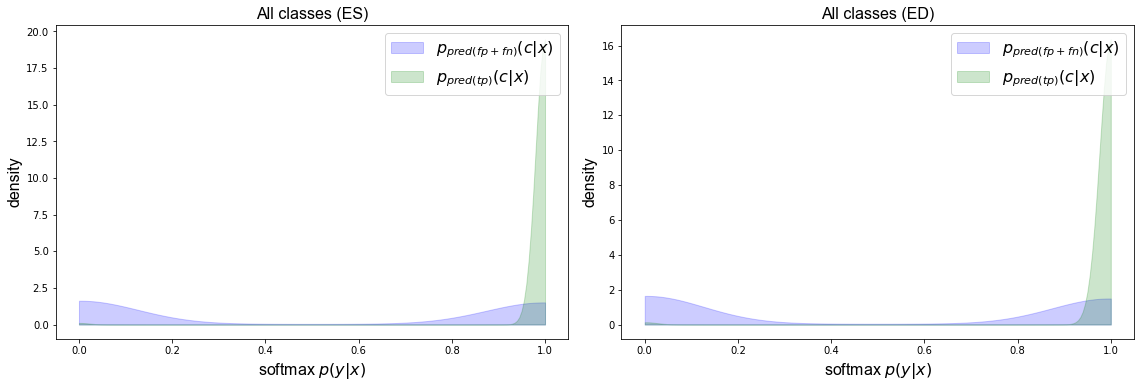

In [68]:
from scipy.stats import gaussian_kde
axis_font = {'fontname': 'Arial', 'size': '16', 'color': 'black', 'weight': 'normal'}
title_font_medium = {'fontname': 'Arial', 'size': '16', 'color': 'black', 'weight': 'normal'}

# info_type = "uncertainty"
info_type = "prob_dist"
image_num = 0
width = 16
height = 10
image_probs_std = exper_hdl_mc.test_results.image_probs_categorized[image_num]
# slice
column_lbls = ["bg", "RV", "MYO", "LV"]
image_probs = exper_hdl_mc.test_results.image_probs_categorized[image_num]
image = exper_hdl_mc.test_results.images[image_num]
label = exper_hdl_mc.test_results.labels[image_num]
img_pred_labels = exper_hdl_mc.test_results.pred_labels[image_num]
num_of_classes = label.shape[0]
half_classes = num_of_classes / 2
num_of_slices = label.shape[3]
num_of_subplots = 2
columns = 2
row = 1
counter = 1
kde = True
if not kde:
    num_of_subplots = 4
    columns = 2
    rows = 2

fig = plt.figure(figsize=(width, height))

for phase in np.arange(2):
            if phase == 0:
                str_phase = "ES"
            else:
                str_phase = "ED"
            p_err_std, p_corr_std = None, None
            for slice in np.arange(num_of_slices):
                img_slice_probs = image_probs[slice]

                for cls in np.arange(half_classes):

                    if slice == 0:
                        if phase == 0:
                            p_err_prob = np.array(img_slice_probs["es_err_p"][cls])
                            p_corr_prob = np.array(img_slice_probs["es_cor_p"][cls])
                            p_err_std = np.array(img_slice_probs["es_err_std"][cls])
                            p_corr_std = np.array(img_slice_probs["es_cor_std"][cls])
                        else:
                                p_err_prob = np.array(img_slice_probs["ed_err_p"][cls])
                                p_corr_prob = np.array(img_slice_probs["ed_cor_p"][cls])
                                p_err_std = np.array(img_slice_probs["ed_err_std"][cls])
                                p_corr_std = np.array(img_slice_probs["ed_cor_std"][cls])
                    else:
                            if phase == 0:
                                p_err_prob = np.concatenate((p_err_prob, np.array(img_slice_probs["es_err_p"][cls])))
                                p_corr_prob = np.concatenate((p_corr_prob, np.array(img_slice_probs["es_cor_p"][cls])))
                                p_err_std = np.concatenate((p_err_std, np.array(img_slice_probs["es_err_std"][cls])))
                                p_corr_std = np.concatenate((p_corr_std, np.array(img_slice_probs["es_cor_std"][cls])))
                            else:
                                p_err_prob = np.concatenate((p_err_prob, np.array(img_slice_probs["ed_err_p"][cls])))
                                p_corr_prob = np.concatenate((p_corr_prob, np.array(img_slice_probs["ed_cor_p"][cls])))
                                p_err_std = np.concatenate((p_err_std, np.array(img_slice_probs["ed_err_std"][cls])))
                                p_corr_std = np.concatenate((p_corr_std, np.array(img_slice_probs["ed_cor_std"][cls])))

            print("{} correct/error(fp+fn) {} / {}".format(str_phase, p_corr_std.shape, p_err_std.shape))
            ax2 = plt.subplot(num_of_subplots, columns, counter)
            if p_err_std is not None:
                if kde:
                    if info_type == "uncertainty":
                        density_err = gaussian_kde(p_err_std)
                        xs_err = np.linspace(0, p_err_std.max(), 200)
                        density_err.covariance_factor = lambda: .25
                        density_err._compute_covariance()
                        ax2.fill_between(xs_err, density_err(xs_err), label="$\sigma_{pred(fp+fn)}$",
                                         color="b", alpha=0.2)
                    else:
                        density_err = gaussian_kde(p_err_prob)
                        xs_err = np.linspace(0, p_err_prob.max(), 200)
                        density_err.covariance_factor = lambda: .25
                        density_err._compute_covariance()
                        ax2.fill_between(xs_err, density_err(xs_err), label="$p_{pred(fp+fn)}(c|x)$",
                                         color="b", alpha=0.2)
                else:
                    xs_err = np.linspace(0, p_err_std.max(), 200)
                    ax2.hist(p_err_std, bins=xs_err, label=r"$\sigma_{pred(fp+fn)}$", color="b", alpha=0.2)

            if p_corr_std is not None:
                if kde:
                    if info_type == "uncertainty":
                        density_cor = gaussian_kde(p_corr_std)
                        xs_cor = np.linspace(0, p_corr_std.max(), 200)
                        density_cor.covariance_factor = lambda: .25
                        density_cor._compute_covariance()
                        ax2.fill_between(xs_cor, density_cor(xs_cor), label=r"$\sigma_{pred(tp)}$",
                                         color="g", alpha=0.2)
                    else:
                        density_cor = gaussian_kde(p_corr_prob)
                        xs_cor = np.linspace(0, p_corr_prob.max(), 200)
                        density_cor.covariance_factor = lambda: .25
                        density_cor._compute_covariance()
                        ax2.fill_between(xs_cor, density_cor(xs_cor), label="$p_{pred(tp)}(c|x)$",
                                         color="g", alpha=0.2)
                else:
                    counter +=1
                    ax3 = plt.subplot(num_of_subplots, columns, counter)
                    xs_cor = np.linspace(0, p_corr_std.max(), 200)
                    ax3.hist(p_corr_std, bins=xs_cor, label=r"$\sigma_{pred(tp)}$", color="g", alpha=0.2)
                    ax3.set_ylabel("density")
                    ax3.set_xlabel("model uncertainty")
                    ax3.legend(loc="best")
            if info_type == "uncertainty":
                ax2.set_xlabel("model uncertainty", **axis_font)
            else:
                ax2.set_xlabel(r"softmax $p(y|x)$", **axis_font)
                
            ax2.set_title("All classes ({})".format(str_phase), **title_font_medium)
            ax2.set_ylabel("density", **axis_font)
            ax2.legend(loc="best", prop={'size': 16})
            
            counter += 1
    
fig.tight_layout()
plt.show()

Number of subplots 20 columns 5 rows 4 slices 0,1


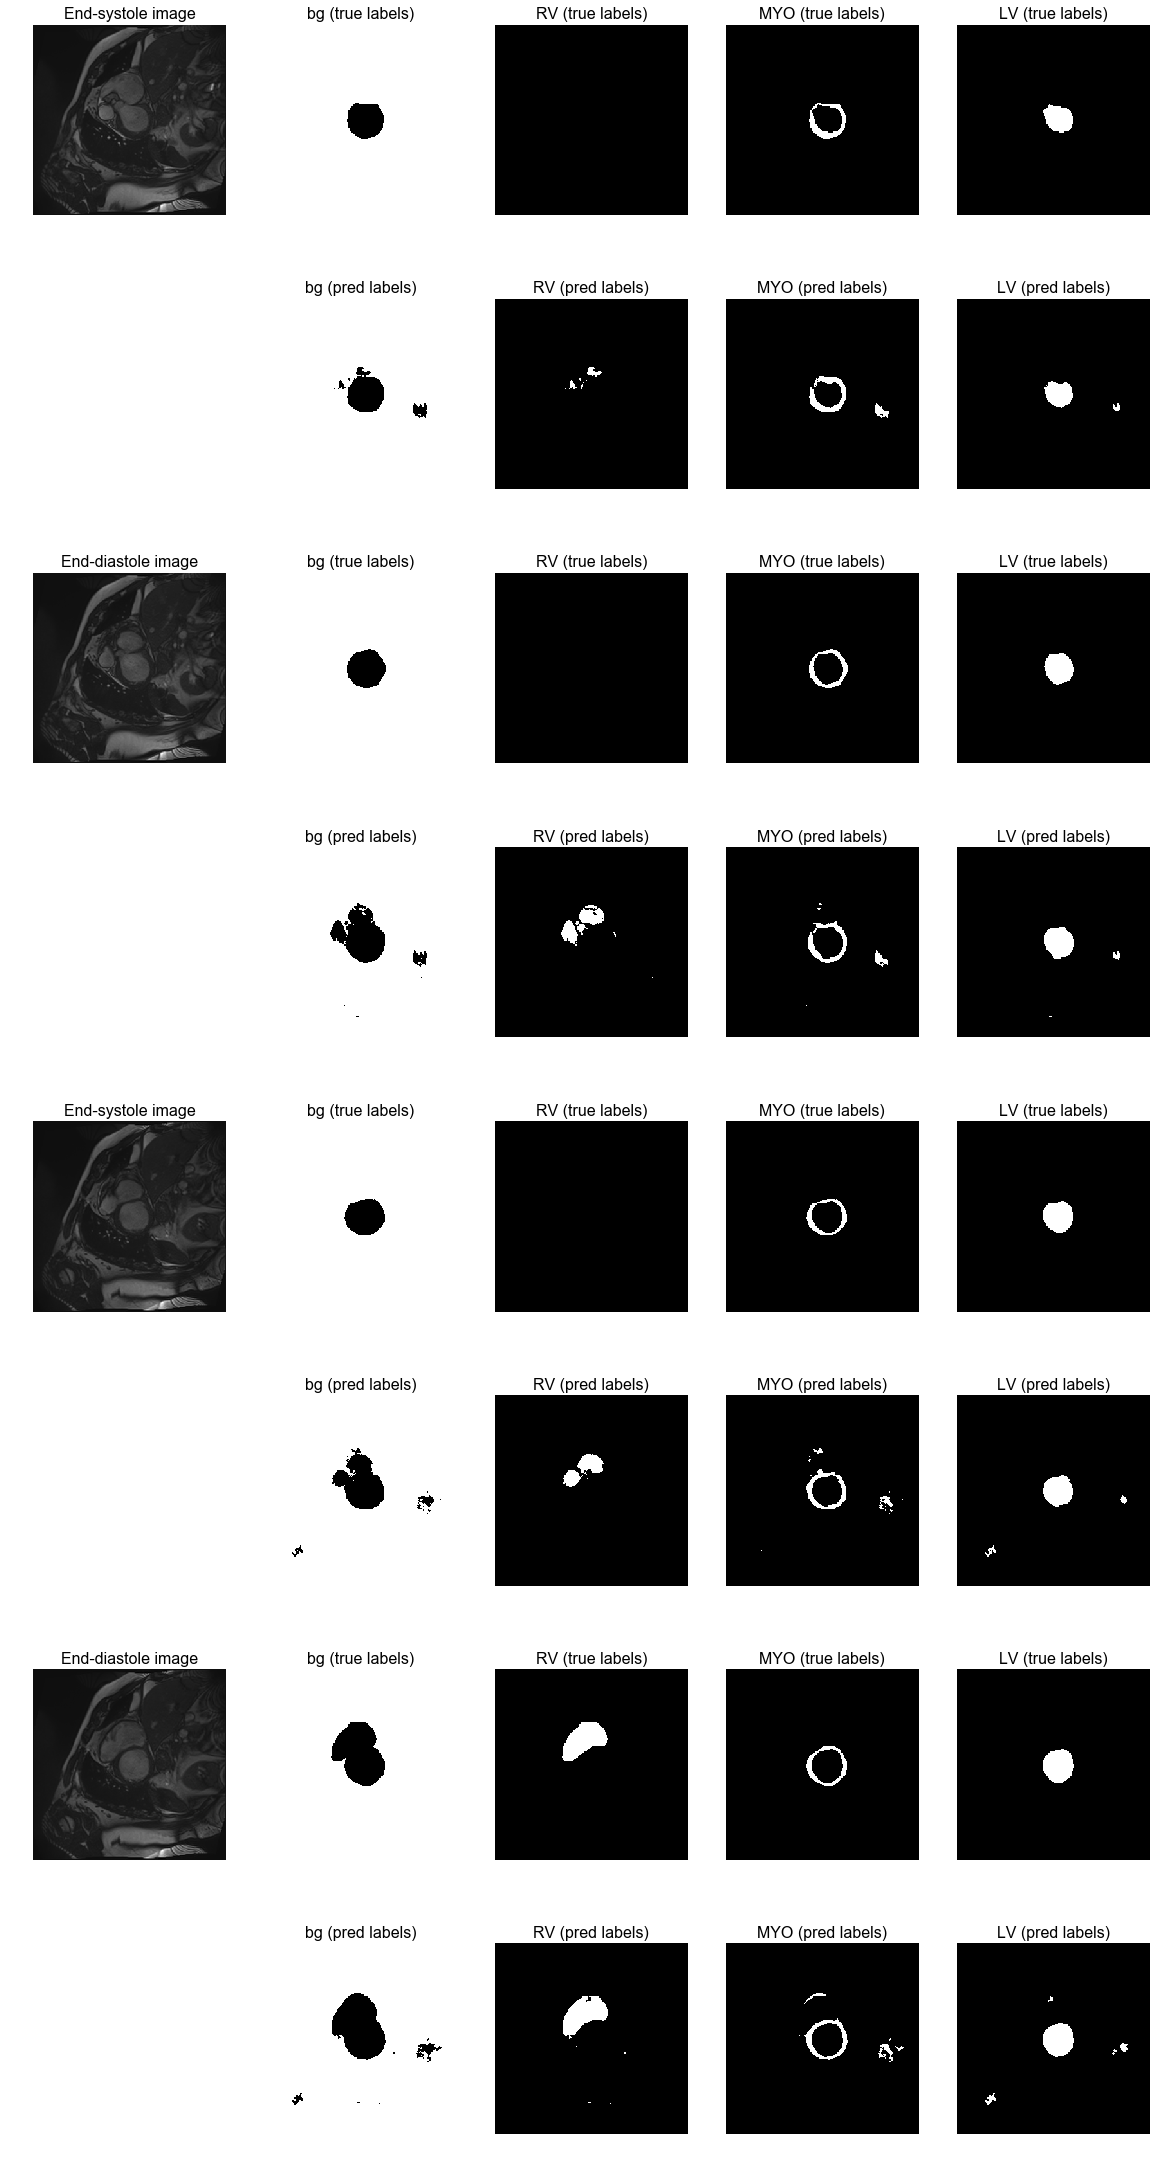

In [16]:
exper_hdl_mc_mix.test_results.visualize_test_slices(width=20, height=100, slice_range=np.arange(0, 2))

Number of subplots 40 columns 5 rows 2 slices 0,1,8,9


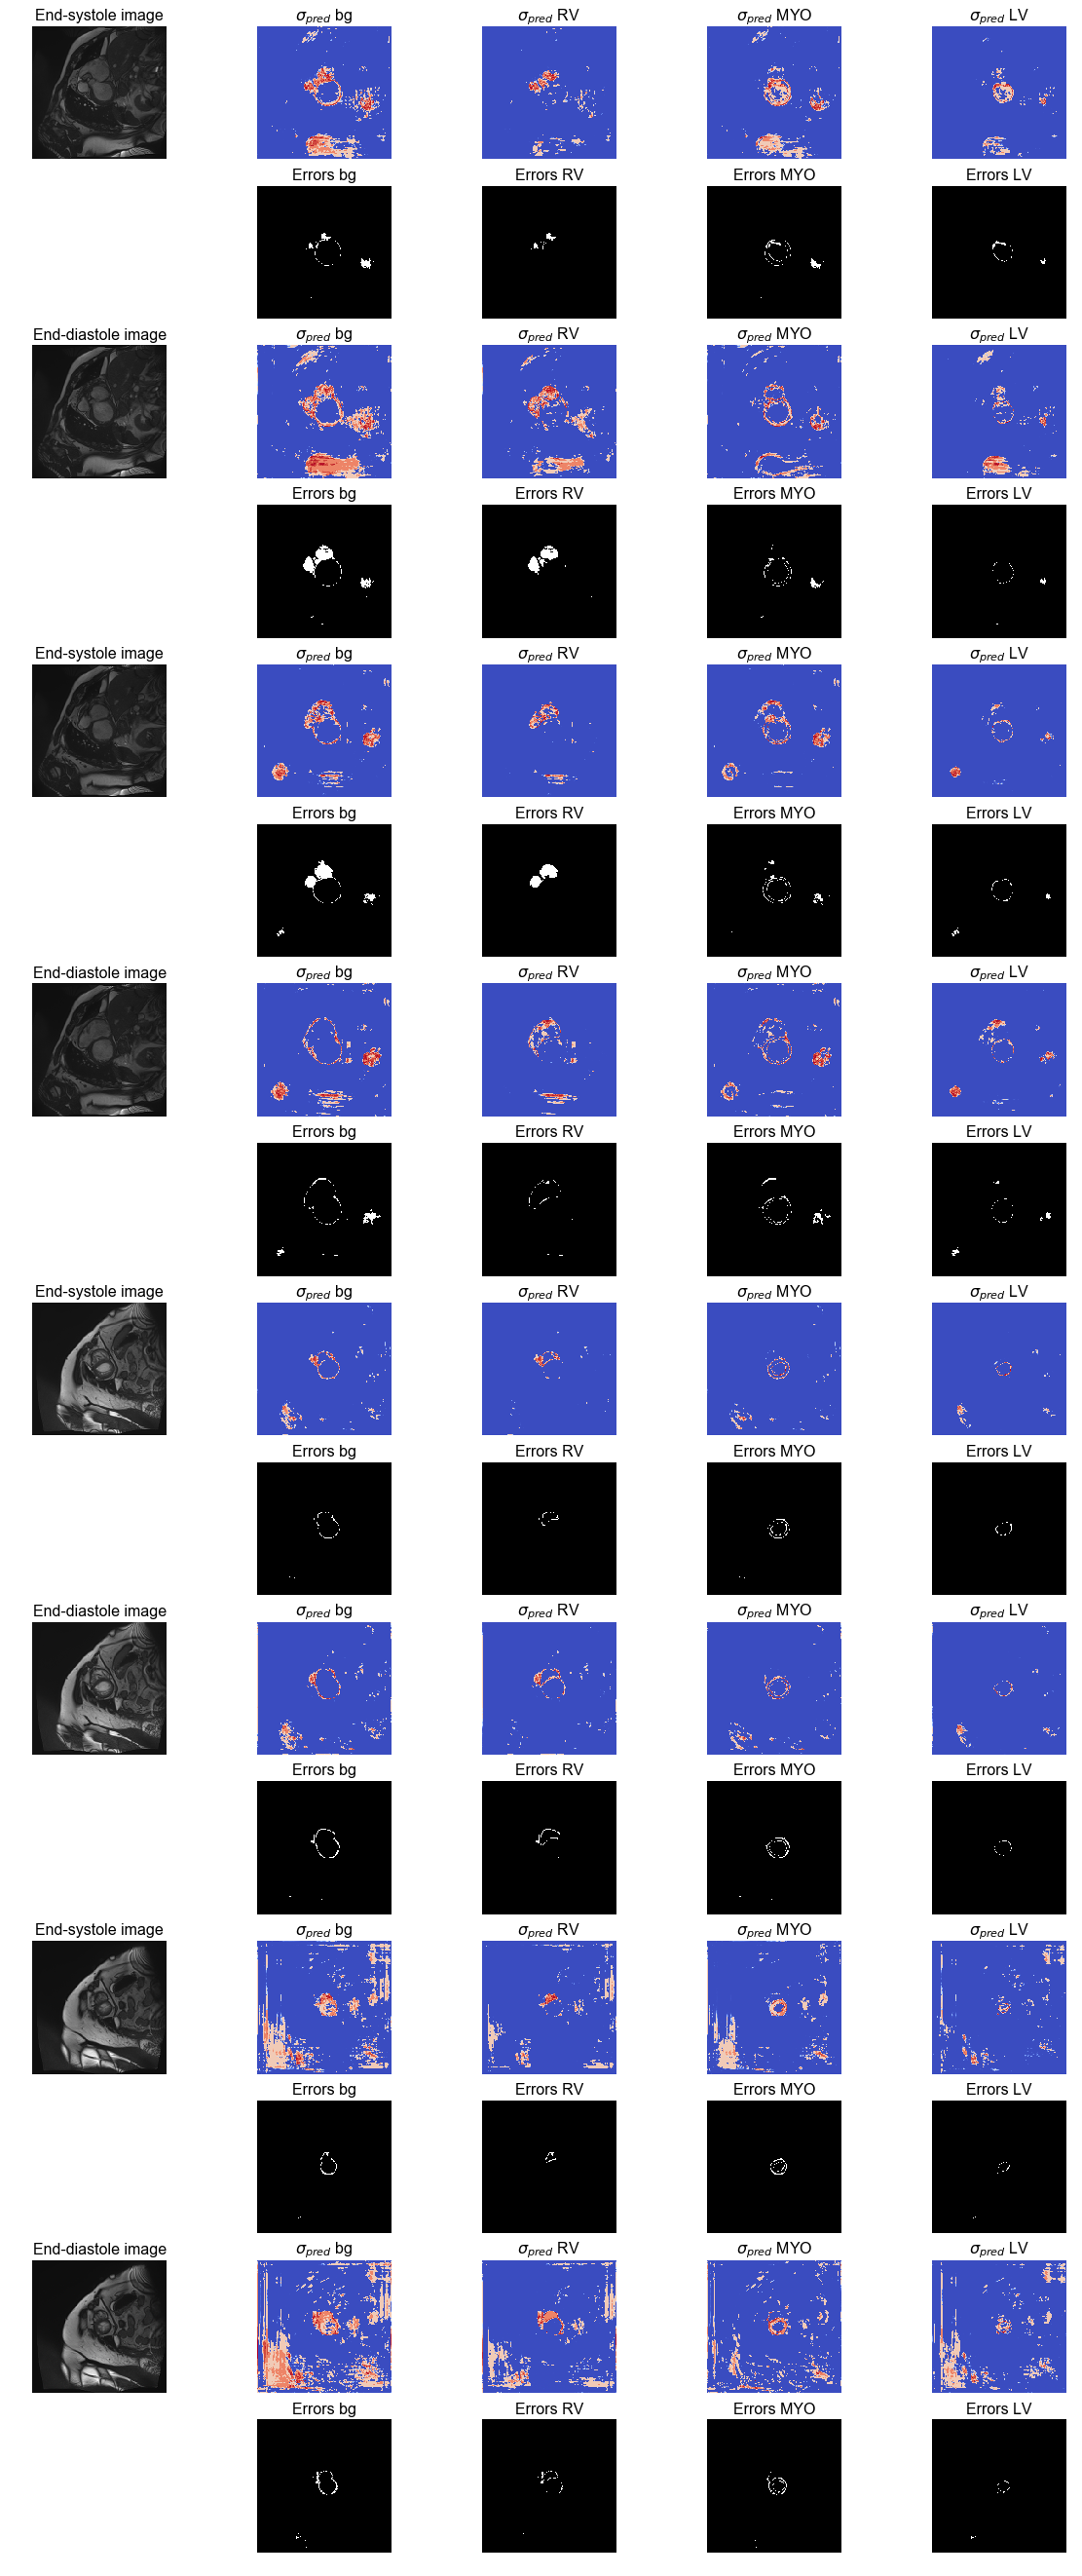

In [43]:
exper_hdl_mc_mix.test_results.visualize_uncertainty(width=20, height=120, slice_range=[0,1,8,9])

In [40]:
len(exper_hdl_base.test_results.test_accuracy)

1